In [1]:
import projectq
from projectq.ops import All, Measure, QubitOperator, TimeEvolution, X
from projectq.ops import CNOT, H, Rz, Rx, Ry, X, Z, Y
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import numpy as np
from numpy.linalg import norm
import pickle
from mpl_toolkits.mplot3d import Axes3D

In [11]:
import pickle
with open("ham_HeH.txt",'rb') as fp:
    qubit_hamiltonians=pickle.load(fp)

# qubit_hamiltonians=qubit_hamiltonians[:20]
qubit_hamiltonians=qubit_hamiltonians[2:22]
n_samples=len(qubit_hamiltonians)
bond_distances=[0.2+0.1*r for r in range(1,21)]
bond_distance = bond_distances

def ham(qubit_hamiltonians,i):
    a_ham=qubit_hamiltonians[i].terms
    ham=0*QubitOperator('Z0')
    for k,v in a_ham.items():
        o_list=[a[1]+str(a[0]) for a in k]
        ham+=v*QubitOperator(' '.join(o_list))
    return ham

In [3]:
def variational_quantum_eigensolver(theta, ham):
    # Create a ProjectQ compiler with a simulator as a backend
    eng = projectq.MainEngine()
    wavefunction = eng.allocate_qureg(4)
    # Initialize the Hartree Fock state |01>
    X | wavefunction[0]
    X | wavefunction[1]
    # build the operator for ansatz wavefunction
    ansatz_op1 = QubitOperator('Y0 Z1 X2')
    ansatz_op2 = QubitOperator('Y1 Z2 X3')
    ansatz_op3 = QubitOperator('Y0 X1 X2 X3')
    # Apply the unitary e^{-i * ansatz_op * t}
    TimeEvolution(theta[0], ansatz_op1) | wavefunction
    TimeEvolution(theta[1], ansatz_op2) | wavefunction
    TimeEvolution(theta[2], ansatz_op3) | wavefunction
    # flush all gates
    eng.flush()

    energy = eng.backend.get_expectation_value(ham, wavefunction)
    
    All(Measure) | wavefunction
    return energy

In [4]:
def loss_H(theta,ham):
    eng = projectq.MainEngine()
    wavefunction = eng.allocate_qureg(4)
    # Initialize the Hartree Fock state |01>
    X | wavefunction[0]
    X | wavefunction[1]
    # build the operator for ansatz wavefunction
    ansatz_op1 = QubitOperator('Y0 Z1 X2')
    ansatz_op2 = QubitOperator('Y1 Z2 X3')
    ansatz_op3 = QubitOperator('Y0 X1 X2 X3')
    # Apply the unitary e^{-i * ansatz_op * t}
    TimeEvolution(theta[0], ansatz_op1) | wavefunction
    TimeEvolution(theta[1], ansatz_op2) | wavefunction
    TimeEvolution(theta[2], ansatz_op3) | wavefunction
    # flush all gates
    eng.flush()
    energy = eng.backend.get_expectation_value(ham, wavefunction) 
    All(Measure) | wavefunction
    return energy

def energies(thetas,hams):
    es=[]
    for i in range(thetas.shape[0]):
        es.append(loss_H(thetas[i],hams[i]))
    return np.array(es)

In [5]:
def grad(theta,ham):
    d=0.01
    d1=np.array([d,0,0])
    d2=np.array([0,d,0])
    d3=np.array([0,0,d])
    g1 = (loss_H(theta+d1,ham)-loss_H(theta-d1,ham))/(2*d)
    g2 =(loss_H(theta+d2,ham)-loss_H(theta-d2,ham))/(2*d)
    g3 =(loss_H(theta+d3,ham)-loss_H(theta-d3,ham))/(2*d)
    return np.array([g1,g2,g3])

def grads(thetas,hams,bc='OBC'):
    gs=[]
    for i in range(thetas.shape[0]):
        gs.append(grad(thetas[i],hams[i]).tolist())
    gs=np.array(gs)
    #if bc == 'OBC':
        #gs[0]=gs[-1]=0
        #gs[0]=0
    return gs

In [6]:
def alpha_term(length,less1,less2,more1,more2,bc = 'OBC'):
        """The arc-length force."""

        res = np.zeros((length, length))
        range_ = range(1, length - 1) if bc == 'OBC' else range(length)
        for i in range_:
            res[i, i] += 2.
            res[i, less1[i]] += -1.
            res[i, more1[i]] += -1.
        return res

def beta_term(length,less1,less2,more1,more2,bc = 'OBC'):
    """The arc-bending force."""

    res = np.zeros((length, length))
    range_ = range(1, length - 1) if bc == 'OBC' else range(length)
    for i in range_:
        res[i, i] += 6.
        # nn
        res[i, less1[i]] += -4.
        res[i, more1[i]] += -4.
        # nnn left
        if bc == 'OBC' and i == 1:
            # mirror-point method
            res[1, 0] += 2.
            res[1, 1] -= 1.
        else:
            res[i, less2[i]] += +1.
        # nnn right
        if bc == 'OBC' and i == length - 2:
            # mirror-point method
            res[length - 2, length - 1] += 2.
            res[length - 2, length - 2] -= 1.
        else:
            res[i, more2[i]] += +1.
    return res

def snake_matrix(alpha,beta,gamma,bc='OBC'):
    id_ = np.arange(n_samples)
    less1 = np.roll(id_, +1)
    less2 = np.roll(id_, +2)
    more1 = np.roll(id_, -1)
    more2 = np.roll(id_, -2)
    length=n_samples
    # implicit time-evolution matrix as in Kass
    A = alpha * alpha_term(length,less1,less2,more1,more2,bc = bc) + beta * beta_term(length,less1,less2,more1,more2,bc = bc)
    inversion_A = np.linalg.inv(A + gamma * np.identity(length))
    #return np.linalg.inv(inversion_A)
    return inversion_A

In [7]:
def training(qubit_hamiltonians,decay_rate=0,learning_rate=1,snake_paras=[0.1,3,5],t_steps=30,stop_e=1e-4):
    thetas=0.1*(np.random.rand(n_samples,3)-0.5)
    gamma=snake_paras[2]
    thetas_history=[thetas] 
    hams=[]
    for i in range(len(qubit_hamiltonians)):
        hams.append(ham(qubit_hamiltonians,i))
        
    for i in range(t_steps):    
        decay=np.exp(-i*decay_rate)
        alpha=snake_paras[0]*decay
        beta=snake_paras[1]*decay
        inv_A=snake_matrix(alpha,beta,gamma)
        thetas=np.dot(inv_A, gamma*thetas-learning_rate*grads(thetas,hams))
        #thetas=np.clip(thetas,0,2*np.pi)
        #thetas=reshape(thetas,n_samples,bc='OBC')
        thetas_history.append(thetas)
        if (i+1)%5==0:            
            print(thetas[[0,10,15,-1]])
    return thetas_history

In [8]:
theta_history=training(qubit_hamiltonians,t_steps=30)

[[-0.00226436 -0.00245372  0.04296172]
 [-0.00963771 -0.01245134  0.0400757 ]
 [-0.00702345 -0.00279296  0.01081508]
 [ 0.0124092   0.00800908  0.00158635]]
[[-0.00243281 -0.00264044  0.04051363]
 [-0.01316587 -0.01531838  0.04127484]
 [-0.0046104  -0.00315111  0.0105877 ]
 [ 0.00473678  0.00294764  0.00203276]]
[[-0.00241575 -0.00262102  0.04077176]
 [-0.0141112  -0.0156762   0.04151684]
 [-0.00390385 -0.00348458  0.01054887]
 [ 0.00164272  0.00091468  0.00224591]]
[[-2.41755497e-03 -2.62306697e-03  4.07445470e-02]
 [-1.43357656e-02 -1.57128616e-02  4.15646376e-02]
 [-3.72859339e-03 -3.65032582e-03  1.05477612e-02]
 [ 3.94228518e-04  9.72554847e-05  2.33726002e-03]]
[[-0.00241736 -0.00262285  0.04074742]
 [-0.01438455 -0.01571195  0.04157331]
 [-0.00369414 -0.00372394  0.01055151]
 [-0.00010972 -0.00023161  0.00237497]]
[[-0.00241738 -0.00262287  0.04074711]
 [-0.01439355 -0.01570951  0.04157451]
 [-0.00369177 -0.0037554   0.01055429]
 [-0.00031316 -0.00036395  0.00239032]]


In [9]:
hams=[]
for i in range(len(qubit_hamiltonians)):
    hams.append(ham(qubit_hamiltonians,i))
snake_energies=energies(theta_history[-1],hams)

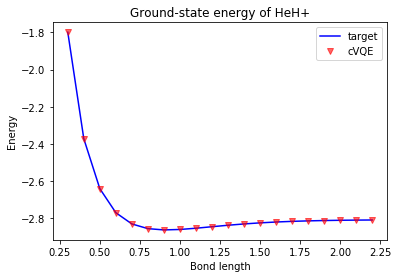

In [12]:
energies_vqe=np.loadtxt("energies.txt")

plt.xlabel("Bond length")
plt.ylabel("Energy")
plt.title("Ground-state energy of HeH+")
plt.plot(bond_distance, energies_vqe,"b-",
         label="target")
plt.plot(bond_distance, snake_energies, "rv",ms=6,alpha=0.6,markevery=1,
         label="cVQE")

plt.legend()
plt.savefig("energy_HeH.jpg",dpi=300)
plt.show()

In [13]:
len(bond_distances[0:-2])

18

In [14]:
energies_vqe

array([-1.79907307, -2.37230184, -2.64071459, -2.77000938, -2.83048296,
       -2.85570863, -2.86261758, -2.86020512, -2.85351619, -2.84542534,
       -2.83749688, -2.83048906, -2.82468268, -2.82009111, -2.81658983,
       -2.81399603, -2.8121175 , -2.8107801 , -2.80983993, -2.80918519])

In [15]:
snake_energies[2:] - energies_vqe[0:-2]

array([-0.84164129, -0.39770742, -0.18976825, -0.08569904, -0.03213422,
       -0.00449597,  0.00910185,  0.01478002,  0.01601937,  0.01493634,
        0.01281438,  0.01039819,  0.00809305,  0.0060952 ,  0.00447239,
        0.00321596,  0.00227759,  0.00159492])

In [16]:
energies_vqe[0:-3]

array([-1.79907307, -2.37230184, -2.64071459, -2.77000938, -2.83048296,
       -2.85570863, -2.86261758, -2.86020512, -2.85351619, -2.84542534,
       -2.83749688, -2.83048906, -2.82468268, -2.82009111, -2.81658983,
       -2.81399603, -2.8121175 ])

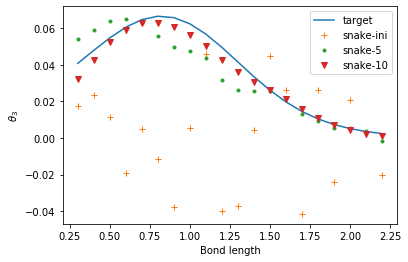

In [17]:
thetas=np.loadtxt("thetas.txt")
bond_distance=bond_distances
plt.xlabel("Bond length")
plt.ylabel("$\\theta_3$")
#plt.title("Evolving snake for VQE")
plt.plot(bond_distance, thetas[:,2], "-",
         label="target")
plt.plot(bond_distance, theta_history[0][:,2], 
         '+',label="snake-ini")
plt.plot(bond_distance, theta_history[1][:,2], 
         '.',label="snake-5")
plt.plot(bond_distance, theta_history[2][:,2], 
         'v',label="snake-10")
plt.legend()
plt.savefig("evolving_snake_theta3.jpg",dpi=300)
plt.show()

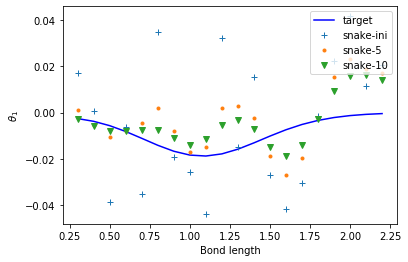

In [18]:
thetas=np.loadtxt("thetas.txt")
bond_distance=bond_distances
plt.xlabel("Bond length")
plt.ylabel("$\\theta_1$")
#plt.title("An evolving snake for VQE")
plt.plot(bond_distance, thetas[:,1], "b-",
         label="target")
plt.plot(bond_distance, theta_history[0][:,1], 
         '+',label="snake-ini")
plt.plot(bond_distance, theta_history[1][:,1], 
         '.',label="snake-5")
plt.plot(bond_distance, theta_history[2][:,1], 
         'v',label="snake-10")
#plt.plot(bond_distance, theta_history[-1][:,1], "r.",
#         label="snake-30")
plt.legend(loc=1)
plt.savefig("evolving_snake_theta2.jpg",dpi=300)
plt.show()

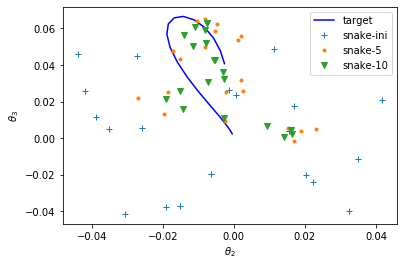

In [19]:
thetas=np.loadtxt("thetas.txt")
bond_distance=bond_distances
plt.xlabel("$\\theta_2$")
plt.ylabel("$\\theta_3$")
#plt.title("An evolving snake for VQE")
plt.plot(thetas[:,1], thetas[:,2], "b-",
         label="target")
plt.plot(theta_history[0][:,1], theta_history[0][:,2], 
         '+',label="snake-ini")
plt.plot(theta_history[1][:,1], theta_history[1][:,2], 
         '.',label="snake-5")
plt.plot(theta_history[2][:,1], theta_history[2][:,2], 
         'v',label="snake-10")
#plt.plot(bond_distance, theta_history[-1][:,1], "r.",
#         label="snake-30")
plt.legend(loc=1)
plt.savefig("evolving_snake_theta23.jpg",dpi=300)

plt.show()

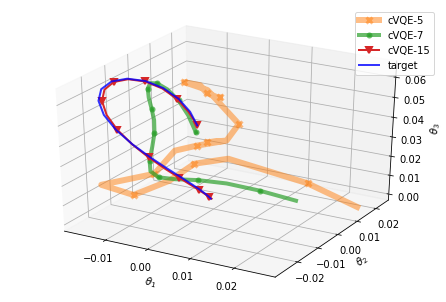

In [20]:
thetas=np.loadtxt("thetas.txt")
bond_distance=bond_distances
fig = plt.figure()
ax = Axes3D(fig)

#plt.title("An evolving snake for VQE")

#ax.plot(theta_history[0][:,0],theta_history[0][:,1], theta_history[0][:,2], 
#         '+',label="snake-ini")
ax.plot(theta_history[1][:,0],theta_history[1][:,1], theta_history[1][:,2], 
         "C1x-",mew=3,lw ='6',alpha=0.5,markevery=2,label='cVQE-5')
ax.plot(theta_history[4][:,0],theta_history[4][:,1], theta_history[4][:,2], 
         "C2.-",mew=3,lw ='4',alpha=0.7,markevery=2,label='cVQE-7')
#ax.plot(theta_history[3][:,0],theta_history[3][:,1], theta_history[3][:,2], 
#         '.-',label="snake-15")

ax.plot(theta_history[-1][:,0],theta_history[-1][:,1], theta_history[-1][:,2], 
         "C3v-",mew=2,lw ='2',alpha=1.0,markevery=2,label='cVQE-15')
#plt.plot(bond_distance, theta_history[-1][:,1], "r.",
#         label="snake-30")

ax.plot(thetas[:,0],thetas[:,1], thetas[:,2], "b-",lw ='2',alpha=0.8,label='target')

plt.legend(loc=1)
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")
ax.set_zlabel("$\\theta_3$")
plt.savefig("evolving_snake_theta123.jpg",dpi=300)
plt.show()



